Load Data from CSV file

In [105]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import numpy as np
import multiprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import dask.dataframe as dd
from nltk.stem import WordNetLemmatizer

In [106]:
input_dir = 'InputData'
data_set_header = ['polarity', 'title', 'review']
PATH_TRAIN_DATA = os.path.join(input_dir, 'train.csv')
PATH_TEST_DATA = os.path.join(input_dir, 'test.csv')
PATH_TRAIN_CLEANED_DATA=os.path.join(input_dir, 'train_cleaned.csv')
PATH_TEST_CLEANED_DATA=os.path.join(input_dir, 'test_cleaned.csv')
DATA_SET_HEADER = ['polarity', 'title', 'review']
max_features = 5000
max_length = 100
sample_number=10000
output_dir = f'Output/textpreprocess/240926/sample_{sample_number}'

In [107]:
def sampling_data(df, num_sample=10000):
    """
    Random sampling of {num_sample} reviews
    
    :param df: Input DataFrame
    :param num_sample: Number to sample
    :return: Sampled DataFrame
    """
    df = df.sample(n=num_sample, random_state=42)  # random_state ensures reproducibility

    return df

In [108]:
def parallel_load_data():
    """
    Load training and test datasets.
    
    :return: Loaded DataFrames for train and test datasets
    """
    df_train = dd.read_csv(PATH_TRAIN_DATA, names=DATA_SET_HEADER)
    df_test = dd.read_csv(PATH_TEST_DATA, names=DATA_SET_HEADER)

    df_train = df_train.compute()
    df_test = df_test.compute()

    df_train = df_train.dropna()
    df_test = df_test.dropna()

    df_train = sampling_data(df_train, sample_number)
    df_test = sampling_data(df_test, int(sample_number*0.2))
    
    return df_train, df_test

In [109]:
df_train, df_test = parallel_load_data()

In [110]:
df_train

,polarity,title,review
41379,1,Wings Over The Pacific,A very poor movie. There were no Germany squar...
6971,1,Disappointed...really disappointed.,I am really disappointed by this Oxo turner. I...
66814,1,"Yes, great descriptions but a bit labored, no?","I'm not sorrry I plowed through this book, but..."
76034,2,Excellent!,Excellent book. The characterization was super...
116125,2,Retro Cap,Perfect Retro cap... I directed a play wherein...
...,...,...,...
69081,2,From Credit Repair to Credit Millionaire,This book opened many doors for me. I did not ...
130400,2,Great Kit!,I had to use this the other day when my rear t...
121683,2,One of the last Marvel hero titles,Marvel has undergone a renaissance in the last...
90233,2,Granddaughter loves this book,I sent this for my 6 yr old granddaughter and ...


In [111]:
# Calulate Memory Usage
memory_usage = df_train.memory_usage(deep=True).sum()

# Convert Memory unit to MB
memory_usage_MB = memory_usage / (1024 ** 2)

# Calulate Memory Usage
memory_usage_test = df_test.memory_usage(deep=True).sum()

# Convert Memory unit to MB
memory_usage_MB_test = memory_usage_test / (1024 ** 2)

# Print Memory usage
print(f"Memory usage of df_train: {memory_usage_MB:.2f} MB / df_test: {memory_usage_MB_test:.2f} MB")

Memory usage of df_train: 5.32 MB / df_test: 1.09 MB


Step 1: Remove stopwords from Dataframe (train, test)

In [112]:
stop_words = set(stopwords.words('english'))

def _expand_contractions(review):
    contractions = {
        "don't": "do not", "I'm": "I am", "you're": "you are", "it's": "it is",
        "he's": "he is", "she's": "she is", "we're": "we are", "they're": "they are",
        "I've": "I have", "you've": "you have", "we've": "we have", "they've": "they have",
        "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
        "haven't": "have not", "hasn't": "has not", "hadn't": "had not",
        "won't": "will not", "wouldn't": "would not", "can't": "cannot", "couldn't": "could not",
        "shouldn't": "should not", "mightn't": "might not", "mustn't": "must not"
    }
    
    contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
    
    def replace(match):
        return contractions[match.group(0)]

    return contractions_re.sub(replace, review)

def _remove_stopwords(review):
    review = _expand_contractions(review)
    
    word_tokens = word_tokenize(review)
    
    filtered_review = [re.sub(r'\W+$', '', word.lower()) for word in word_tokens if word.lower() not in stop_words]
    
    filtered_review = ' '.join(filtered_review).strip()
    filtered_review = re.sub(' +', ' ', filtered_review) 
    
    return filtered_review

def _process_reviews_chunk(reviews_chunk):
    return reviews_chunk.apply(_remove_stopwords)

def parallel_remove_stopwords(df, col_name='review'):
    num_cores = multiprocessing.cpu_count() 
    pool = multiprocessing.Pool(num_cores)   

    review_chunks = np.array_split(df[col_name], num_cores)
    processed_chunks = pool.map(_process_reviews_chunk, review_chunks)

    df[col_name] = pd.concat(processed_chunks)
    
    pool.close()
    pool.join()

    return df

def _lemmatize_reviews_chunk(reviews_chunk):
    lemmatizer = WordNetLemmatizer()
    return reviews_chunk.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

def parallel_word_net_lemmatizer(df, col_name='review'):
    num_cores = multiprocessing.cpu_count() 
    pool = multiprocessing.Pool(num_cores)   

    review_chunks = np.array_split(df[col_name], num_cores)

    processed_chunks = pool.map(_lemmatize_reviews_chunk, review_chunks)

    df[col_name] = pd.concat(processed_chunks)

    pool.close()
    pool.join()

    return df

def word_net_lemmatizer(df, col_name='review'):
    lemmatizer = WordNetLemmatizer()
    df[col_name] = df[col_name].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    return df

def count_sentence_words_count(df, col_name='review'):
    df[f'{col_name}_length'] = df[col_name].apply(lambda x: len(x.split()))
    return df

def get_plot(df,col_name='review_length'):
    review_length_counts = df[col_name].value_counts().sort_index()

    cumulative_percentage = np.cumsum(review_length_counts.values) / np.sum(review_length_counts.values) * 100

    length_70_percent = review_length_counts.index[np.argmax(cumulative_percentage >= 70)]
    length_90_percent = review_length_counts.index[np.argmax(cumulative_percentage >= 90)]

    plt.figure(figsize=(20, 6))
    plt.bar(review_length_counts.index, review_length_counts.values, color='skyblue')
    plt.axvline(x=length_70_percent, color='red', linestyle='--', label=f'70% at {length_70_percent} words')
    plt.axvline(x=length_90_percent, color='green', linestyle='--', label=f'80% at {length_90_percent} words')
    plt.xlabel('Review Length (Number of Words)', fontsize=12)
    plt.ylabel('Number of Reviews', fontsize=12)
    plt.title('Distribution of Review Lengths in f_X_train', fontsize=14)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

    print('Max sentence length: ', max(review_length_counts.index))
    print('sentence length - 70%: ',length_70_percent)
    print('sentence length - 90%: ',length_90_percent)
    return length_90_percent +1 

In [113]:
df_train_step1 = parallel_remove_stopwords(df_train.copy())
df_train_step1 = parallel_word_net_lemmatizer(df_train_step1)

# df_train_step1 = df_train

/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


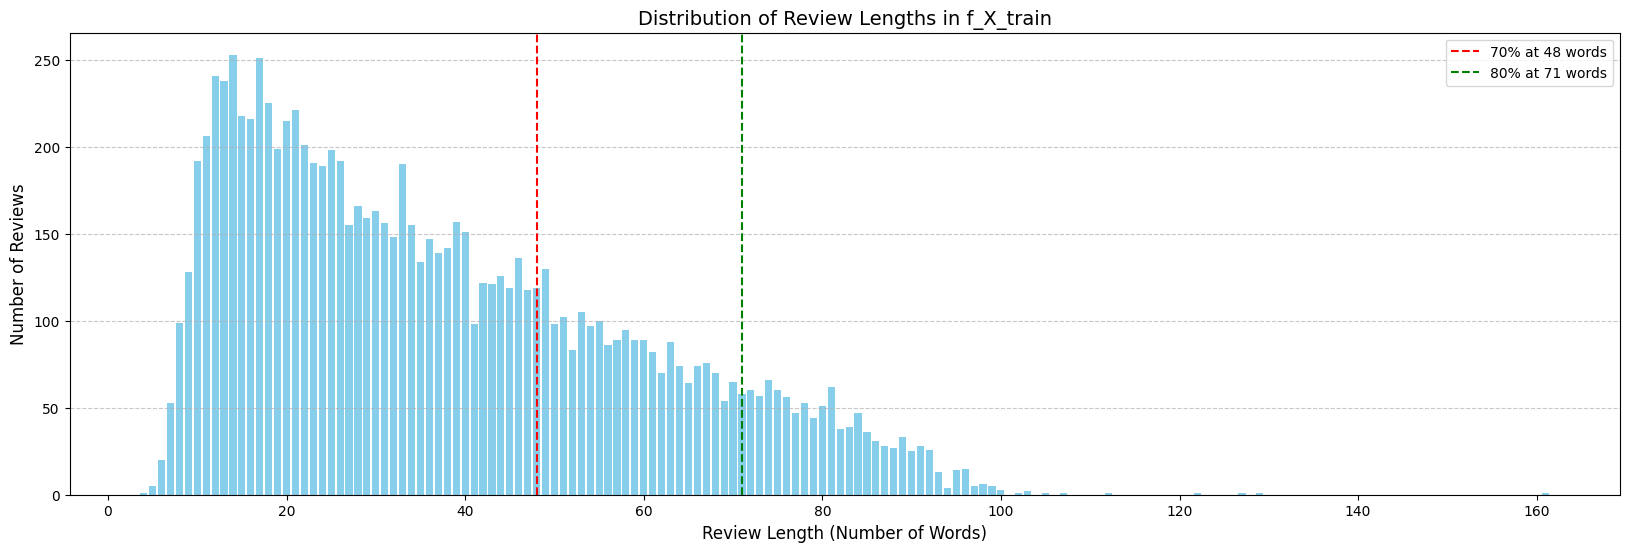

Max sentence length:  161
sentence length - 70%:  48
sentence length - 90%:  71
Filtering Target sentence Length:  72


In [114]:
df_train_step1_length = count_sentence_words_count(df_train_step1.copy())
max_length = get_plot(df_train_step1_length)
print('Filtering Target sentence Length: ', max_length)

Step 2: Filtering up to 70% of the maximum sentence length.

In [115]:
def filter_by_length_of_sentence(df, max_length):
    # Add a new column to store the length of each review (in terms of word count)
    df['review_length'] = df['review'].apply(lambda x: len(x.split()))
    
    # Debug: Check maximum length before filtering
    print(f"Maximum review length before filtering: {df['review_length'].max()}")

    # Filter reviews that have a word count less than or equal to the specified max_length
    filtered_data = df[df['review_length'] <= max_length]
    
    # Debug: Check maximum length after filtering
    print(f"Maximum review length after filtering: {filtered_data['review_length'].max()}")

    return filtered_data

In [116]:
df_train_step2  = df_train
df_train_step2 = filter_by_length_of_sentence(df_train_step1.copy(), max_length)

Maximum review length before filtering: 161
Maximum review length after filtering: 72


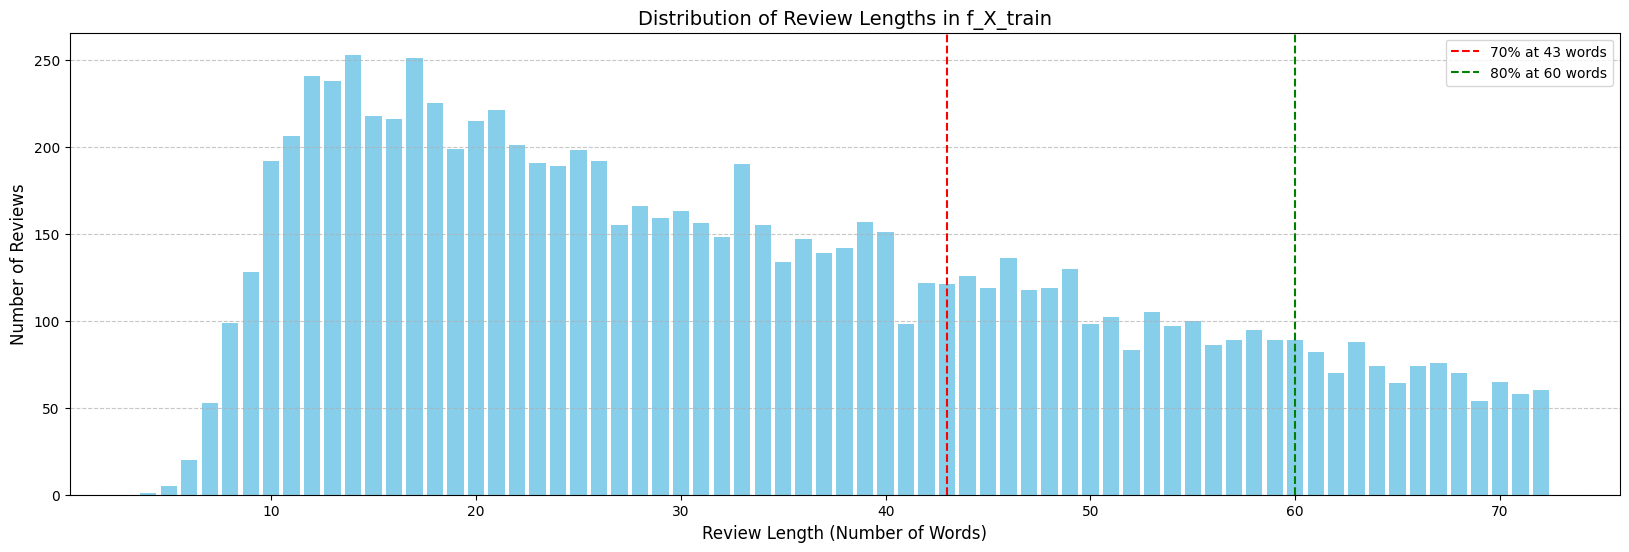

Max sentence length:  72
sentence length - 70%:  43
sentence length - 90%:  60


61

In [117]:
df_train_step2_length = count_sentence_words_count(df_train_step2.copy())
get_plot(df_train_step2_length)

In [118]:
print(f'Compare Shapes train: {df_train.shape} / train_step1: {df_train_step1.shape} / train_step2: {df_train_step2.shape}')

Compare Shapes train: (10000, 3) / train_step1: (10000, 3) / train_step2: (9071, 4)


In [119]:
df_train_step2 = df_train_step2.drop(columns='review_length')
df_train_step2

,polarity,title,review
41379,1,Wings Over The Pacific,poor movie germany squardons pacific poor acti...
6971,1,Disappointed...really disappointed.,really disappointed oxo turner used first time...
66814,1,"Yes, great descriptions but a bit labored, no?",sorrry plowed book sure would give great revie...
76034,2,Excellent!,excellent book characterization superb jake zo...
116125,2,Retro Cap,perfect retro cap directed play wherein one ch...
...,...,...,...
29588,1,Diaper Champ,diaper champ arrived old address even changed ...
130400,2,Great Kit!,use day rear tire got leak worked like charm h...
121683,2,One of the last Marvel hero titles,marvel undergone renaissance last year term cr...
90233,2,Granddaughter loves this book,sent 6 yr old granddaughter love picture turn ...


In [120]:
# Calulate Memory Usage
memory_usage = df_train.memory_usage(deep=True).sum()
# Convert Memory unit to MB
memory_usage_MB = memory_usage / (1024 ** 2)

# Calulate Memory Usage
memory_usage_step1 = df_train_step1.memory_usage(deep=True).sum()
# Convert Memory unit to MB
memory_usage_MB_step1 = memory_usage_step1 / (1024 ** 2)

# Calulate Memory Usage
memory_usage_step2 = df_train_step2.memory_usage(deep=True).sum()
# Convert Memory unit to MB
memory_usage_MB_step2 = memory_usage_step2 / (1024 ** 2)

# Print Memory usage
print(f"Memory usage of df_train: {memory_usage_MB:.2f} MB / df_train_step1: {memory_usage_MB_step1:.2f} MB/ df_train_step2: {memory_usage_MB_step2:.2f} MB")

Memory usage of df_train: 5.33 MB / df_train_step1: 3.85 MB/ df_train_step2: 3.23 MB


Step 3: drop title column, save cleaned csv file

In [121]:
df_train_step3 = df_train_step2.drop(columns='title')
print(df_train_step2)

df_train_step3.to_csv(PATH_TRAIN_CLEANED_DATA, index = False)

        polarity                                           title  \
41379          1                          Wings Over The Pacific   
6971           1             Disappointed...really disappointed.   
66814          1  Yes, great descriptions but a bit labored, no?   
76034          2                                      Excellent!   
116125         2                                       Retro Cap   
...          ...                                             ...   
29588          1                                    Diaper Champ   
130400         2                                      Great Kit!   
121683         2              One of the last Marvel hero titles   
90233          2                   Granddaughter loves this book   
82695          1                     not the same of the picture   

                                                   review  
41379   poor movie germany squardons pacific poor acti...  
6971    really disappointed oxo turner used first time...  
668

Clean test data

/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


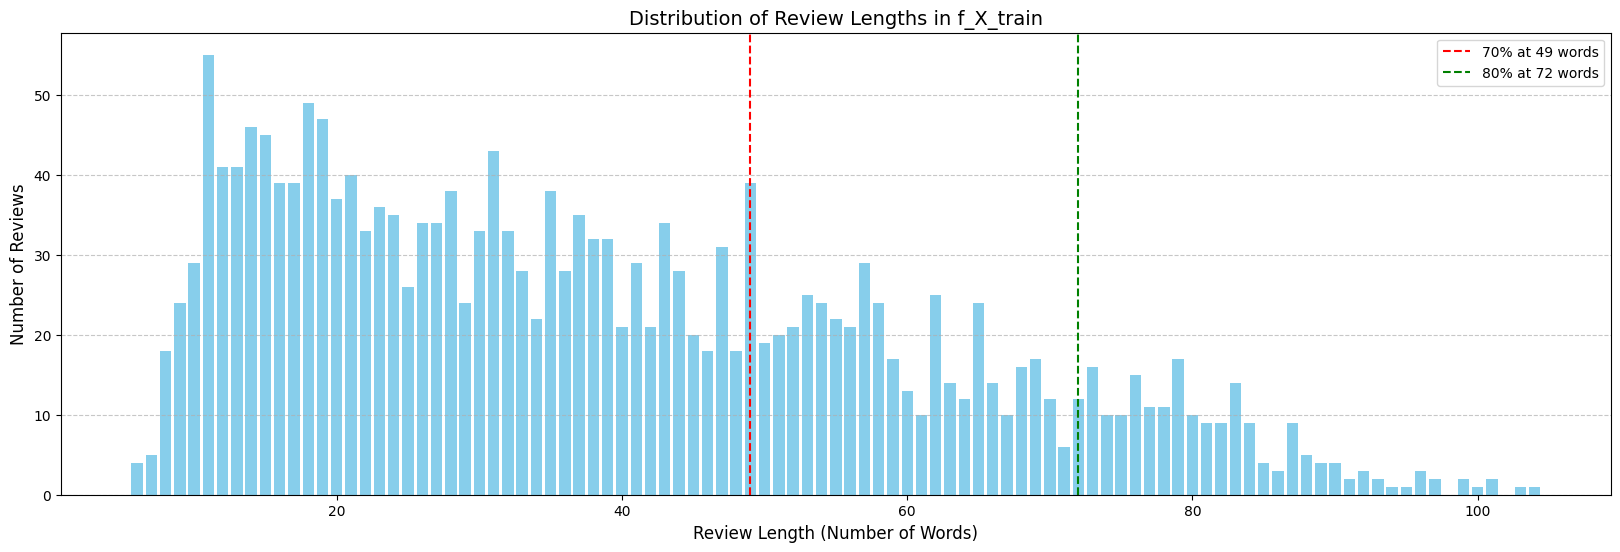

Max sentence length:  104
sentence length - 70%:  49
sentence length - 90%:  72
Filtering Target sentence Length:  73
Maximum review length before filtering: 104
Maximum review length after filtering: 72


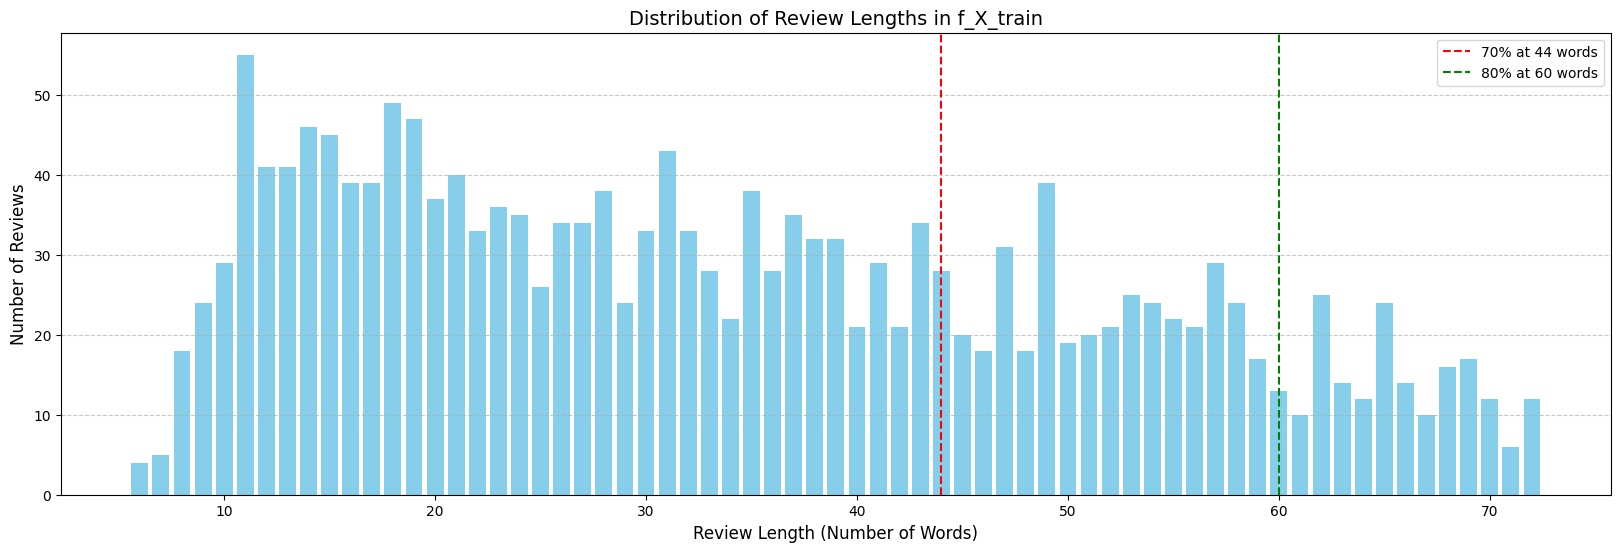

Max sentence length:  72
sentence length - 70%:  44
sentence length - 90%:  60
Compare Shapes test: (2000, 3) / test_step1: (2000, 3) / test_step2: (1809, 4)
Memory usage of df_test: 1.09 MB / df_test_step1: 0.78 MB/ df_test_step2: 0.66 MB
        polarity                                              title  \
136071         2          Great book fior the Psyco. in your family   
18278          2  Great Book (There's the understatement of the ...   
10465          1                                     already broken   
188084         1                                Don't buy! Illegal!   
56157          2                                       A Great Book   
...          ...                                                ...   
156246         2                                            LaVinia   
71604          2                            Good, comfortable grips   
139764         1                                   Not what it says   
13948          1      Very Disappointing, Heavily 

In [122]:
df_test_step1 = parallel_remove_stopwords(df_test.copy())
df_test_step1 = parallel_word_net_lemmatizer(df_test_step1)
# df_test_step1 = df_test
df_test_step1_length = count_sentence_words_count(df_test_step1.copy())
print('Filtering Target sentence Length: ', get_plot(df_test_step1_length))
df_test_step2 = df_test
df_test_step2 = filter_by_length_of_sentence(df_test_step1.copy(), max_length)
df_test_step2_length = count_sentence_words_count(df_test_step2.copy())
get_plot(df_test_step2_length)
print(f'Compare Shapes test: {df_test.shape} / test_step1: {df_test_step1.shape} / test_step2: {df_test_step2.shape}')
df_test_step2 = df_test_step2.drop(columns='review_length')
df_test_step2

# Calulate Memory Usage
memory_usage = df_test.memory_usage(deep=True).sum()
# Convert Memory unit to MB
memory_usage_MB = memory_usage / (1024 ** 2)
# Calulate Memory Usage
memory_usage_step1 = df_test_step1.memory_usage(deep=True).sum()
# Convert Memory unit to MB
memory_usage_MB_step1 = memory_usage_step1 / (1024 ** 2)
# Calulate Memory Usage
memory_usage_step2 = df_test_step2.memory_usage(deep=True).sum()
# Convert Memory unit to MB
memory_usage_MB_step2 = memory_usage_step2 / (1024 ** 2)

# Print Memory usage
print(f"Memory usage of df_test: {memory_usage_MB:.2f} MB / df_test_step1: {memory_usage_MB_step1:.2f} MB/ df_test_step2: {memory_usage_MB_step2:.2f} MB")

df_test_step3 = df_test_step2.drop(columns='title')
print(df_test_step2)

df_test_step3.to_csv(PATH_TEST_CLEANED_DATA, index = False)

Step 4: Vectorize for LogisticRegression, XGBoost, NaiveBayse

In [123]:
df_train_read = pd.read_csv(PATH_TRAIN_CLEANED_DATA)
df_test_read = pd.read_csv(PATH_TEST_CLEANED_DATA)

In [124]:
from scipy.sparse import vstack

vectorizer = TfidfVectorizer(max_features=10000)
def vectorize_text(X_train, X_test):
    """
    Perform TF-IDF vectorization on the training and test datasets.
    
    :param X_train: Training text data
    :param X_test: Test text data
    :return: TF-IDF transformed X_train and X_test
    """
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf

def _fit_transform_chunk(X_chunk):
    """
    Perform TF-IDF fit_transform on a chunk of the data.
    """
    return vectorizer.fit_transform(X_chunk)

def _transform_chunk(X_chunk):
    """
    Perform TF-IDF transform on a chunk of the data.
    """
    return vectorizer.transform(X_chunk)

def _clean_text(text):
    """
    Check if the input is a string, and handle NaN or non-string values.
    """
    if isinstance(text, str):
        return text
    else:
        return ""
    
def parallel_vectorize_text(X_train, X_test):
    """
    Perform TF-IDF vectorization on the training and test datasets using parallel processing.
    
    :param X_train: Training text data
    :param X_test: Test text data
    :return: TF-IDF transformed X_train and X_test
    """
    X_train = X_train.apply(_clean_text)
    X_test = X_test.apply(_clean_text)

    num_cores = multiprocessing.cpu_count()  # Use all CPU cores
    pool = multiprocessing.Pool(num_cores)

    # Split data into chunks for parallel processing
    X_train_chunks = np.array_split(X_train, num_cores)
    X_test_chunks = np.array_split(X_test, num_cores)

    # Parallel fit_transform for X_train
    X_train_tfidf_chunks = pool.map(_fit_transform_chunk, X_train_chunks)

    # Parallel transform for X_test
    X_test_tfidf_chunks = pool.map(_transform_chunk, X_test_chunks)

    # Combine the results from each chunk
    X_train_tfidf = vstack(X_train_tfidf_chunks)
    X_test_tfidf = vstack(X_test_tfidf_chunks)

    # Close the pool
    pool.close()
    pool.join()

    return X_train_tfidf, X_test_tfidf

In [125]:
def split_data(df):
    """
    Split the dataset into training and test sets.
    
    :param df: Input DataFrame
    :return: Training and test sets for X and y
    """
    X = df['review']  # Feature: review text
    y = df['polarity']  # Target: sentiment polarity

    return X, y

In [126]:
def preprocess(df):
    """
    Preprocess the dataset by converting polarity to binary labels.
    
    :param df: Input DataFrame
    :return: Preprocessed DataFrame with binary labels
    """
    df['polarity'] = df['polarity'].map({1: 0, 2: 1})  # 1 for negative, 2 for positive
    return df

In [127]:
df_train_read = preprocess(df_train_read)
df_test_read = preprocess(df_test_read)

In [128]:
X_train, y_train = split_data(df_train_read)
X_test, y_test = split_data(df_test_read)

In [129]:
X_train_tfidf, X_test_tfidf = vectorize_text(X_train, X_test)

Save result

In [130]:
import joblib

# 저장할 디렉토리 설정 (필요 시 생성)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the vectorizer and the model
joblib.dump(vectorizer, os.path.join(output_dir, 'vectorizer.pkl'))
joblib.dump(X_train_tfidf, os.path.join(output_dir, 'X_train_tfidf.pkl'))
joblib.dump(X_test_tfidf, os.path.join(output_dir, 'X_test_tfidf.pkl'))
joblib.dump(y_train, os.path.join(output_dir, 'y_train.pkl'))
joblib.dump(y_test, os.path.join(output_dir, 'y_test.pkl'))

['Output/textpreprocess/240926/sample_10000/y_test.pkl']

: 